# Time Series Modeling for Real Estate Investments

*Problem Statement*



In [85]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#customising our plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

plt.style.use('fivethirtyeight')

#timeseries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA

In [3]:
#import data set

data  = pd.read_csv('zillow_data.csv')

data.shape

(14723, 272)

In [4]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
#checking number of columns
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [6]:
#defing a function to check for missing values
def missing_data(df):
    missing_data = df.isna().sum()
    missing_data = missing_data[missing_data>0]
    return missing_data.to_frame()

In [7]:
#checking for missing values 
data[['RegionID', 'RegionName', 'City', 'Metro', 'CountyName', 'SizeRank' ]].isna().sum()

RegionID         0
RegionName       0
City             0
Metro         1043
CountyName       0
SizeRank         0
dtype: int64

In [8]:
#checkig for number of unique states
data['State'].nunique()

51

In [9]:
#checking for the unique values for metro feature
data['Metro'].nunique()

701

## Data Cleaning

In [10]:
#renaming the Region names to Zipcode

data.rename(columns= {'RegionName': 'ZipCode'}, inplace= True)

In [11]:
#sanity check
data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Notice that the 8th feature comprises the dates when the valuation of the house was performed. However, the columns are identified as strings. In the following steps, the columns will be converted to datetime format to allow for manipulation.

In [12]:
def get_datetimes(df):
    """
    Takes a dataframe and converts the column names starting from the 8th column
    to datetime objects, returning the modified dataframe.
    """
    # Convert the column names starting from the 8th column to datetime objects
    datetime_columns = pd.to_datetime(df.columns.values[7:], format='%Y-%m')
    
    # Replace the original column names with the new datetime objects
    df.columns = list(df.columns.values[:7]) + list(datetime_columns)
    
    return df

# Applying the function to the data dataframe
data = get_datetimes(data)


In [13]:
#sanity check
data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [14]:
#drop RegionID column.
data.drop(columns= 'RegionID', inplace= True)

- `ZipCode` is a categorical feature, therefore we convert it to object instead of integer.

In [15]:
#coverting Zipcode to object
data['ZipCode'] = data['ZipCode'].astype('object')

In [16]:
# expanding the number of visible columns
pd.set_option('display.max_columns', None)

In [17]:
#checking missing data in every column
missing_data(data).T

,Metro,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01 00

Notice there are a lot of missing data. Let's explore the missing data column by column.

In [18]:
#sampling 10 records with missing values of `Metro`
data.loc[pd.isna(data['Metro'])].sample(10)

,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:

When examining records with missing values in the 'metro' feature, a pattern emerges indicating that these cities or zip codes share certain characteristics. In the United States, a Metropolitan Statistical Area (MSA) is defined by the Office of Management and Budget (OMB) as having at least one urbanized area with a population of 50,000 or more, including surrounding counties with significant social and economic integration, typically assessed through commuting patterns. Cities such as Hesperia, Sabetha, Alcolu, and Devils Lake do not qualify as metro areas according to the dataset as of April 2018 because they fall short of these criteria. These cities are relatively small, with populations significantly below the threshold required for an MSA, and their surrounding areas lack the population density and economic integration needed to constitute a larger metropolitan area. Instead of discarding these records, we will replace the missing 'metro' values with `No Metro` to maintain the integrity of our dataset as this may play a valuable role in the value of a house.

In [19]:
#replacing the null values in the metro column
data.fillna({'Metro': 'No Metro'}, inplace= True)

In [20]:
#sanity check
data.loc[pd.isna(data['Metro'])]

,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:

In [21]:
#Setting pandas display options to show more decimal places and avoid scientific notation
pd.set_option('display.float_format', lambda x: f"{x:.2f}")

In [22]:
data.describe()

,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01

In [23]:
data.loc[pd.isna(data[pd.Timestamp('1996-04-01 00:00:00')])].sample(10)

,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:

In [24]:
#checking the unique feature in the SizeRank
data['SizeRank'].nunique()

14723

The feature `SizeRank` is an identity feature therefore does not tell us much about the cities nor the value of the houses. Therefore the column shall be dropped in this project.

In [25]:
#dropping SizeRank
data.drop(columns= 'SizeRank', inplace = True)

In [26]:
#sanity check
data.head()

,ZipCode,City,State,Metro,CountyName,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,201

*sorting the zipcodes*

In [27]:
#converting all zipcodes to be 5 characters as it is the standard

data['ZipCode'] = data['ZipCode'].apply(lambda x: str(x).rjust(5, '0'))

In [28]:
#sample sanity check
data['ZipCode'].min()

'01001'

*Creating New feature, ROI*
- The Return on Investment (ROI) will also be calculated to evaluate the benefit that an investor receives in relation to the cost of their investment across various ZipCodes.

$$
ROI = \frac{\text{Current Investment} - \text{Cost of Investment}}{\text{Cost of Investment}}
$$


In [29]:
#creating a new feature `ROI`

data['ROI'] = (data[pd.Timestamp('2018-04-01 00:00:00')]/ data[pd.Timestamp('1996-04-01 00:00:00')]) - 1

In [30]:
#Sanity check
data.head()

,ZipCode,City,State,Metro,CountyName,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,201

### Exploratory Data Analysis

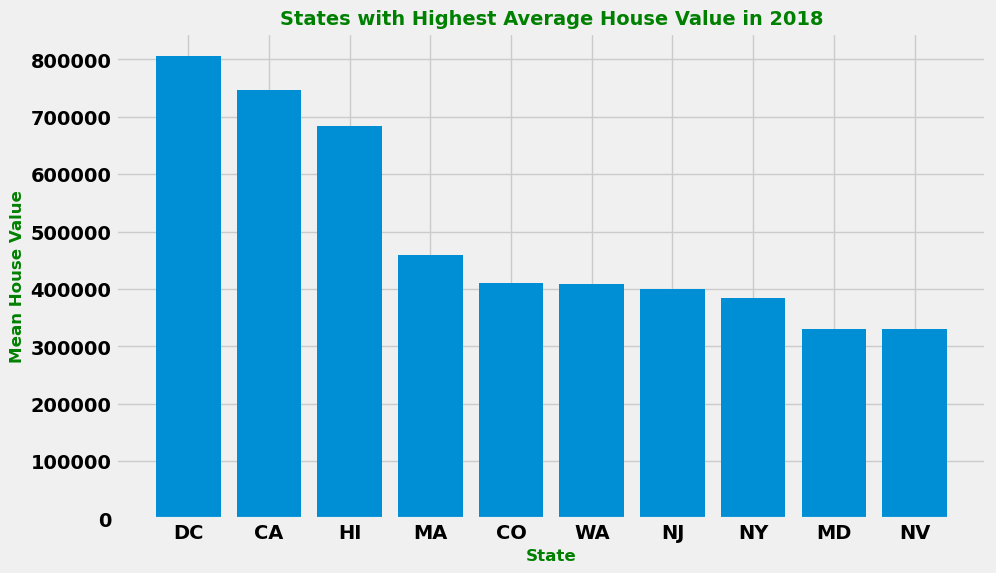

In [31]:
#Top 10 states to inverst in 2018 April.
date_column = pd.Timestamp('2018-04-01 00:00:00')

# Group by 'ZipCode', then aggregate by summing the values for the specific date
top_10 = data.groupby('State')[date_column].mean().nlargest(10)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(top_10.index, top_10.values)

#setting the labels
ax.set_xlabel('State', fontsize=12, color='green', fontweight='bold', fontname='sans-serif')
ax.set_ylabel('Mean House Value', size = 12, weight = 'bold', color = 'Green', fontname='sans-serif')
ax.set_title('States with Highest Average House Value in 2018', color= 'Green', weight = 'bold', 
                        size= 14, fontname='sans-serif');


- The average price of a house in DC in 2018 was USD800000 and USD350000 in Nevada.

- Looking at these states, you notice they have diversified economies. California, for instance, is home to Silicon Valley, Hollywood, and major agricultural sectors. Massachusetts has a strong educational and healthcare sector. DC is the political center of the country, and Hawaii has a robust tourism industry. 

- All these factors create a competitive market where housing prices are driven to high levels due to the attractiveness of these states for living, working, and investing making them the most expensive house markets in the US.

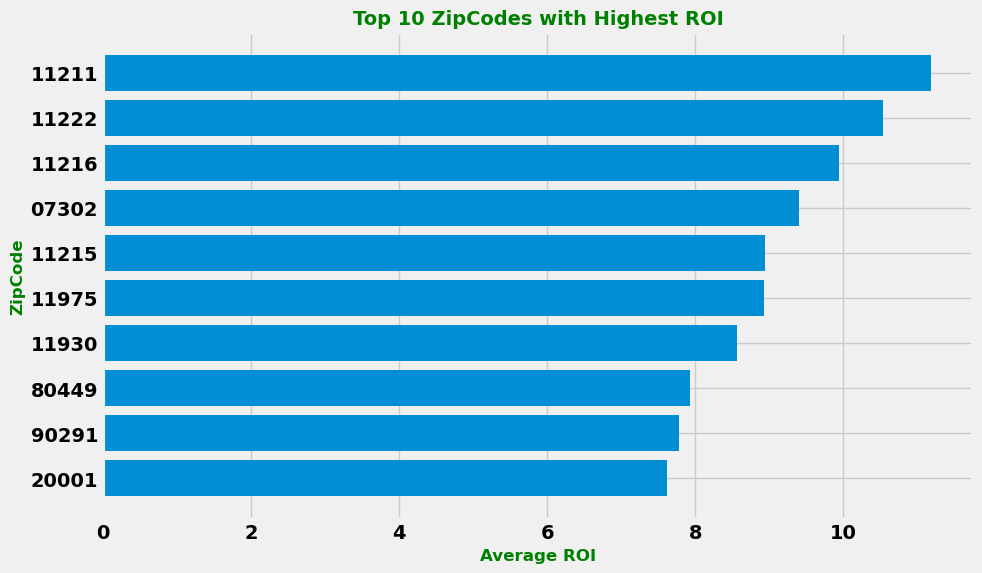

In [32]:
#Top 10 ZipCodes with highest ROI
top10_ROI = data.groupby('ZipCode')['ROI'].mean().nlargest(10)[::-1]

fig, ax = plt.subplots(figsize = (10, 6))

ax.barh(y= top10_ROI.index, width= top10_ROI)


#setting the labels
ax.set_xlabel('Average ROI', fontsize=12, color='green', fontweight='bold', fontname='sans-serif')
ax.set_ylabel('ZipCode', size = 12, weight = 'bold', color = 'Green', fontname='sans-serif')
ax.set_title('Top 10 ZipCodes with Highest ROI', color= 'Green', weight = 'bold', 
                        size= 14, fontname='sans-serif');


**Insights**

- ZIP codes 11211, 11222, 11216, and 11215 are located in Brooklyn, NY, an area that has undergone significant gentrification and development over the past few decades, making it a highly desirable location.
- ZIP codes 11975 and 11930 cover parts of the Hamptons, a highly sought-after area known for luxury homes and vacation properties.
- ZIP code 07202 is located in Elizabeth, New Jersey, a city that benefits from its proximity to New York City, making it a convenient and attractive location for commuters.

- When analyzing these areas, a common trend emerges: properties in these ZIP codes have experienced high appreciation rates due to factors such as their proximity to major cities, significant urban gentrification, and the appeal of suburban luxury, as seen in the Hamptons. 

- These factors collectively contribute to strong housing ROI in these areas, making them particularly attractive to real estate investors.

In [33]:
#more EDA

*Reshape from Wide to Long Format*


In [34]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State',
                                   'Metro', 'CountyName', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'])
    melted = melted.dropna(subset=['value'])
    return  melted.groupby('time').aggregate({'value':'mean'})

In [35]:
#copying the data
df = data.copy()

In [36]:
#reshaping the new df to long format

df = melt_data(data)

In [37]:
#Renaming the value to mean
df.rename(columns= {'value': 'Mean_Value'}, inplace= True)

In [86]:
df.tail(12)

,Mean_Value
time,
2017-05-01,270226.84
2017-06-01,271824.72
2017-07-01,273335.39
2017-08-01,274865.77
2017-09-01,276464.62
2017-10-01,278033.19
2017-11-01,279520.86
2017-12-01,281095.32
2018-01-01,282657.06


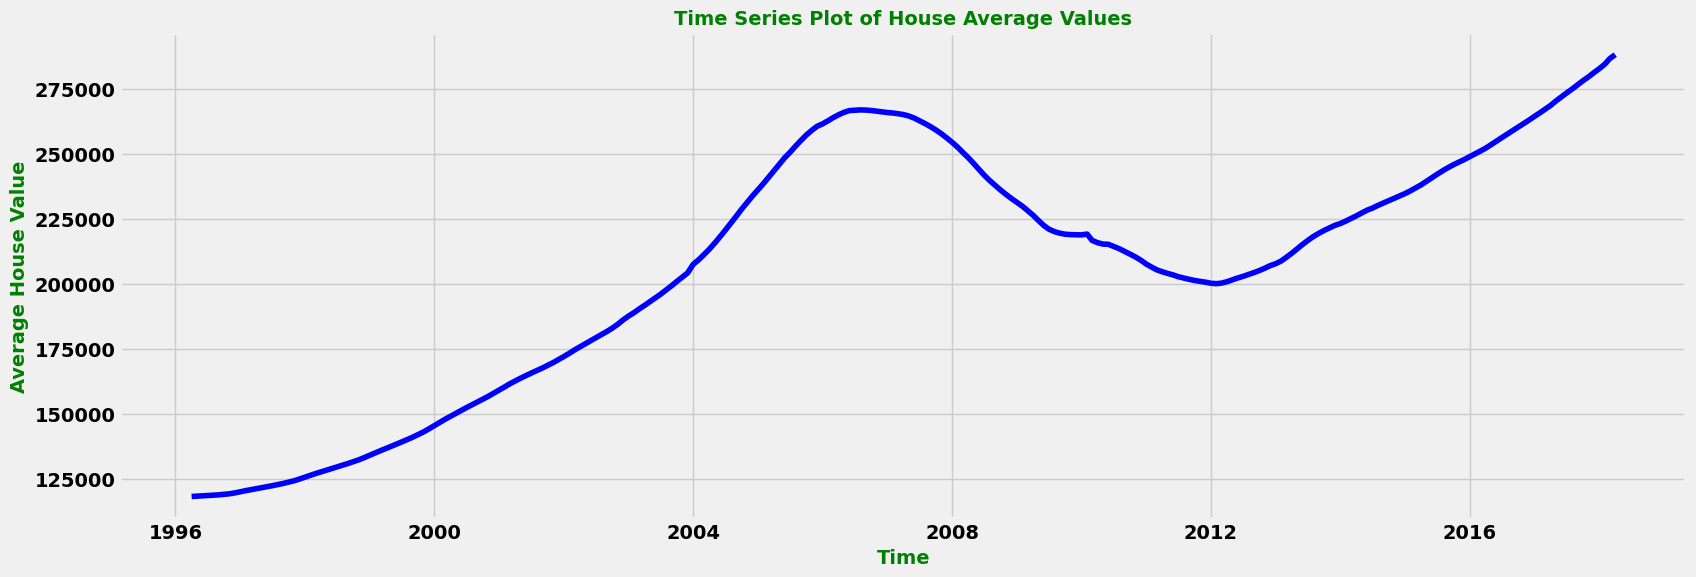

In [113]:
#ploting the trend in the value of the houses
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df, color = 'b')
plt.xlabel('Time', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.ylabel('Average House Value', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')

plt.title('Time Series Plot of House Average Values', color= 'Green', 
                            weight = 'bold', size= 14, fontname='sans-serif');


- The trend appears cyclical with an overall upward trajectory over time.
- The average value of houses increased significantly from 1996 to 2018.
- The pattern shows periods of growth, followed by dips or plateaus, then resuming upward. This cyclical nature reflects economic and market cycles.
- The plot peaks around 2007-2008 due to several factors:
  - Early 2000s: The Federal Reserve kept interest rates low, making borrowing cheaper. This increased mortgage lending and housing demand, driving up house values.
  - 2007-2008: Interest rates reset higher, leading to many homeowners, especially with subprime mortgages, defaulting on loans. Increased defaults led to foreclosures, flooding the market with homes and causing prices to plummet.
- Post-2008 decline explained by the Great Recession:
  - The financial crisis led to widespread unemployment, reduced consumer spending, and a lack of economic confidence, further depressing house prices.
  - Banks tightened lending standards, making it harder for buyers to get mortgages, reducing housing demand.
- Post-2012 rise attributed to economic stabilization:
  - The economy began stabilizing, with improving unemployment rates and consumer confidence.
  - The Federal Reserve kept interest rates low to stimulate the economy, making borrowing more affordable and encouraging home purchases.

**Checking for Stationarity**

In [40]:
# Determine rolling statistics
roll_mean = df.rolling(window=12, center=False).mean()
roll_std = df.rolling(window=12, center=False).std()

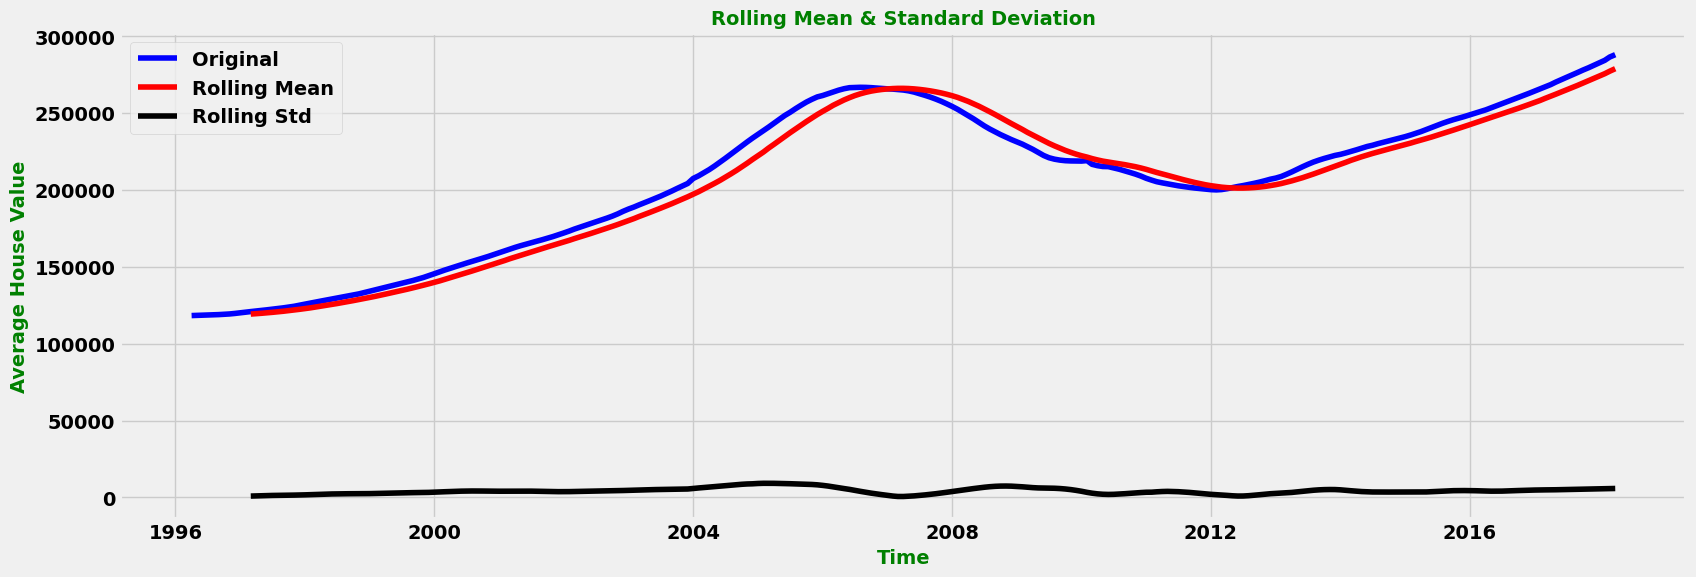

In [112]:
# Plot rolling statistics
fig = plt.figure(figsize=(18,6))
plt.plot(df, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Time', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.ylabel('Average House Value', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.title('Rolling Mean & Standard Deviation', color= 'Green', weight = 'bold', 
                        size= 14, fontname='sans-serif')
plt.show()

- The rolling mean closely follows the original data, indicating a strong trend component. The rolling standard deviation remains relatively stable over time, suggesting that the variability of the series does not change significantly, although the trend does.

In [42]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df['Mean_Value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -1.89
p-value                         0.34
#Lags Used                      2.00
Number of Observations Used   262.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


- The results of the Dickey-Fuller Test indicate that the test statistic is -1.89, with a p-value of 0.34. 

- Since the test statistic is less negative than the critical values at the 1%, 5%, and 10% significance levels (-3.46, -2.87, and -2.57, respectively), and the p-value is higher than the typical thresholds for significance (0.01, 0.05, 0.10), we fail to reject the null hypothesis of the test. 

- Therefore there is insufficient evidence to conclude that the time series is stationary, meaning the serries non-stationarity.

*Removing Trend*

We look at the plots of the differenced (1-lag) series.

In [72]:
df_diff = df.diff(periods= 1).dropna()

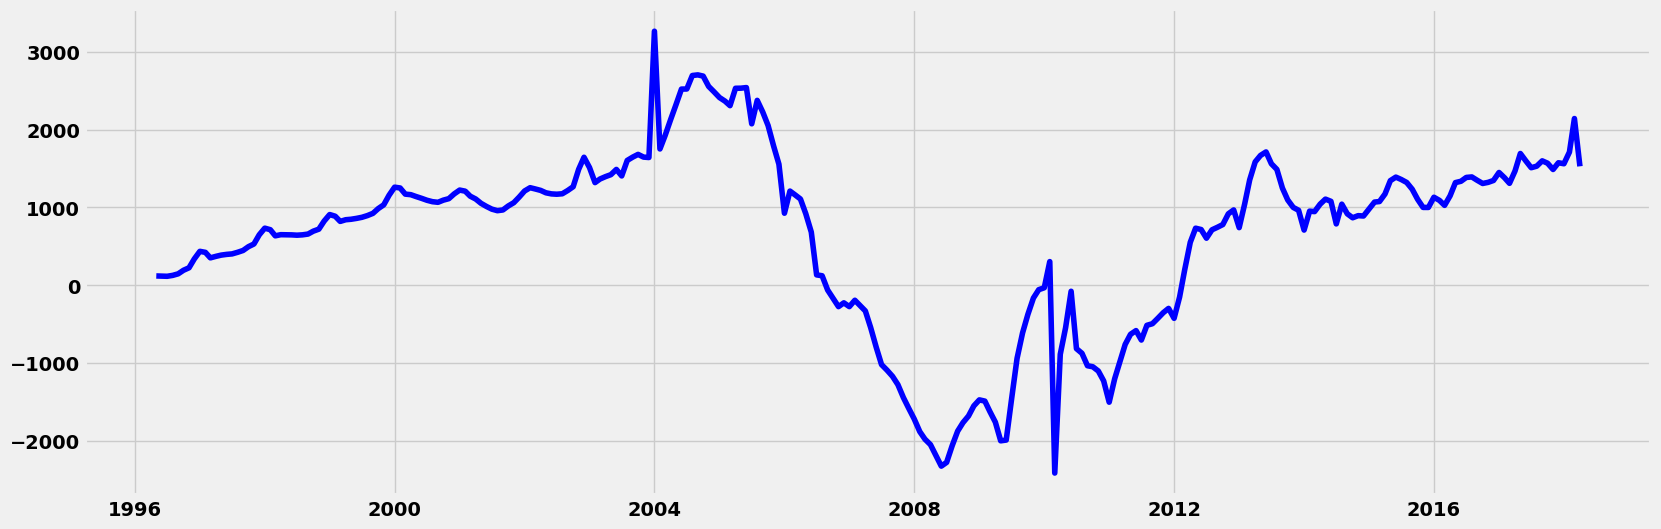

In [73]:
fig = plt.figure(figsize=(18,6))
plt.plot(df_diff, color='blue');